# Sentient Classifier to predict whether the person/people are sad or happy

# 1.1 Import necessary dependencies

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip list

Package                      Version
---------------------------- -----------
absl-py                      2.3.0
asttokens                    3.0.0
astunparse                   1.6.3
certifi                      2025.6.15
charset-normalizer           3.4.2
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.3.2
cycler                       0.12.1
debugpy                      1.8.14
decorator                    5.2.1
executing                    2.2.0
flatbuffers                  25.2.10
fonttools                    4.58.4
gast                         0.6.0
google-pasta                 0.2.0
grpcio                       1.73.0
h5py                         3.14.0
idna                         3.10
ipykernel                    6.29.5
ipython                      9.3.0
ipython_pygments_lexers      1.1.1
jedi                         0.19.2
jupyter_client               8.6.3
jupyter_core                 5.8.1
keras                        3.10.0

In [3]:
import tensorflow as tf
import os #To navigate through file structures
import matplotlib as plt

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
len(gpus)

0

In [5]:
#Avoid OOM (Out of Memory) errors by setting GPU Memory Consumption Growth so that tensorflow doesn't use all the VRAM 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 1.2 Removing Dodgy Images

In [6]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [7]:
import cv2
from PIL import Image
from matplotlib import pyplot as plt

In [8]:
data_dir = 'data'  #Storing the path as a variable

In [9]:
os.listdir(data_dir)

['happy', 'sad']

In [10]:
image_exts = ['JPEG', 'JPG', 'BMP', 'PNG',]

### cv2 and os in action

In [11]:
img = cv2.imread(os.path.join('data','happy','960x0.jpg'))

In [12]:
type(img)

numpy.ndarray

In [13]:
img.shape

(640, 960, 3)

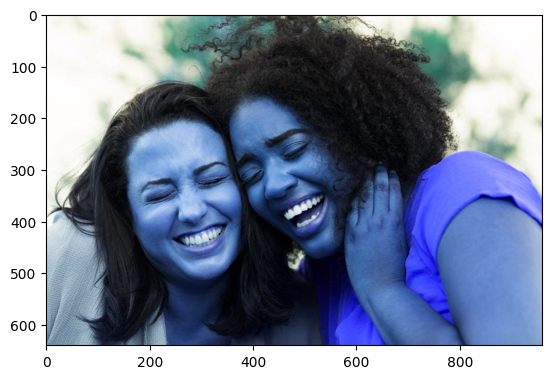

In [14]:
plt.imshow(img)
plt.show()

### Removing dodgy images

In [15]:
for image_class in os.listdir(data_dir):                                     # Loop through folders in the directory
    for image in os.listdir(os.path.join(data_dir, image_class)):            # Loop through images in each folder
        image_path = os.path.join(data_dir, image_class, image)
        try:
            # Try opening with PIL to validate image
            with Image.open(image_path) as img_check:
                img_format = img_check.format.upper()
            
            if img_format not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
            else:
                # Optionally load with OpenCV after format check
                img = cv2.imread(image_path)

        except Exception as e:
            print('Issue with image {}'.format(image_path))

Issue with image data\happy\.ipynb_checkpoints
Issue with image data\sad\.ipynb_checkpoints


# 1.3 Load the data

In [16]:
#tf.data.Dataset??

In [17]:
import numpy as np
from matplotlib import pyplot as plt

### Note : This helper builds the dataset on the fly so we don't need to build the classes, labels by ourselves as well as does some preprocessing like resizing the images

In [18]:
#tf.keras.utils.image_dataset_from_directory??

In [19]:
data = tf.keras.utils.image_dataset_from_directory('data')  #Building our data pipeline

Found 179 files belonging to 2 classes.


### Note : As this dataset is not preloaded into memory but is a "Generator", we can't just look at the data through indices. By converting into numpy iterator, we can access the generator from our data pipeline

In [20]:
data_iterator = data.as_numpy_iterator()  #Allows to access the data pipeline, allowing to loop through it

In [21]:
batch = data_iterator.next() #Accessing the data pipeline, grabbing one batch back

In [22]:
#Images represented as numpy arrays, 32 = Batch Size
batch[0].shape

(32, 256, 256, 3)

In [23]:
#Labels
#Class 1 : Sad People
#Class 0 : Happy People
batch[1].shape

(32,)

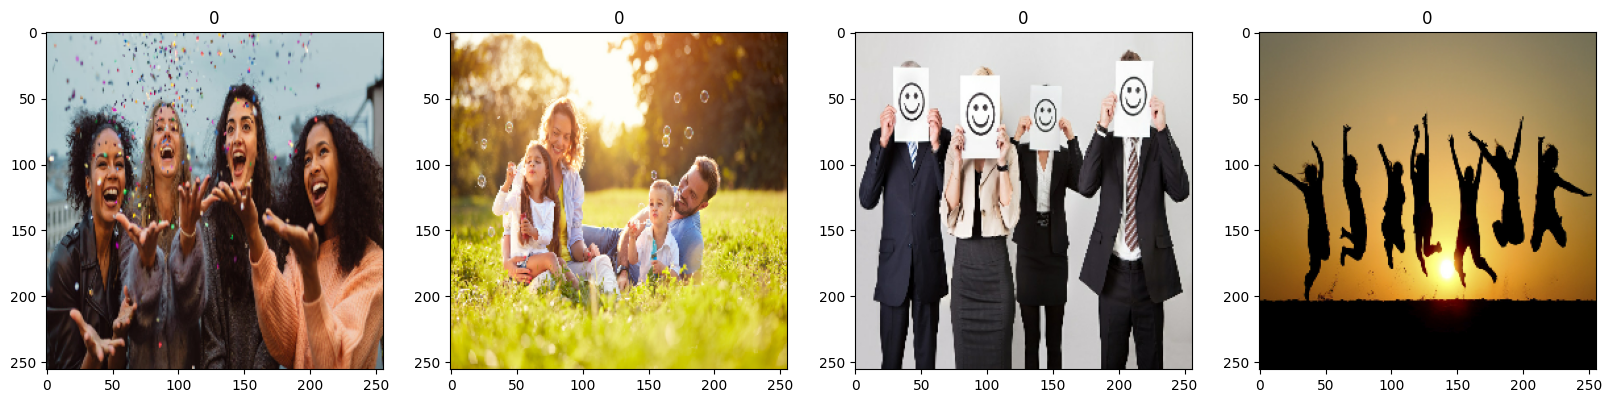

In [24]:
fig, ax = plt.subplots(ncols=4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 2. Preprocessing Data

## 2.1 Scale Data

In [25]:
data = data.map(lambda x,y: (x/255, y))

In [26]:
scaled_iterator = data.as_numpy_iterator()

In [27]:
batch = scaled_iterator.next()

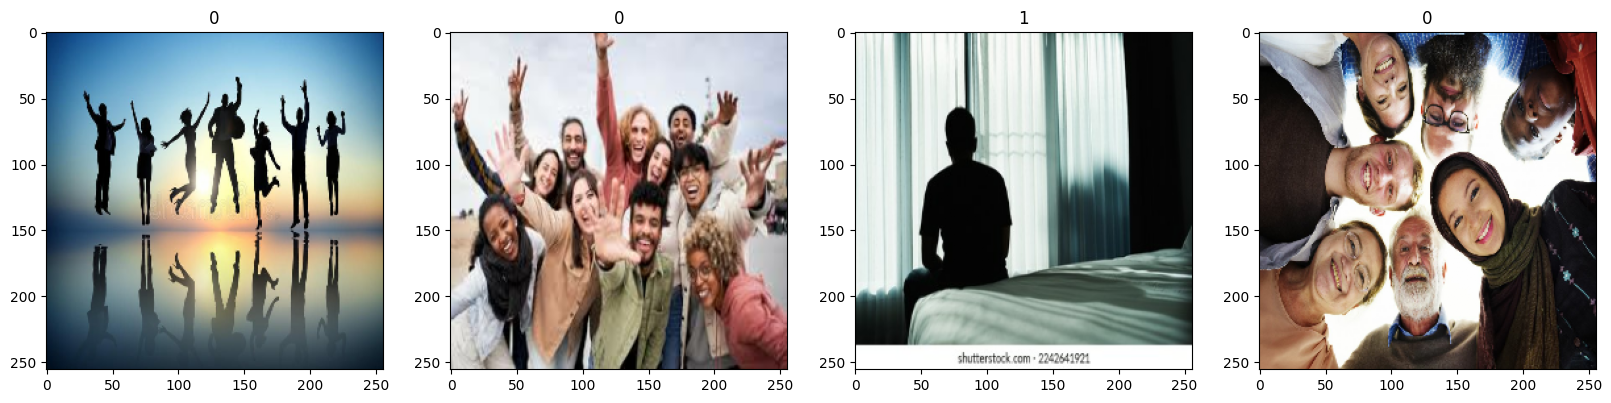

In [28]:
fig, ax = plt.subplots(ncols=4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## 2.2 Split Data

In [29]:
len(data)

6

In [30]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [31]:
train_size + val_size + test_size

6

In [32]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [33]:
len(val)

1

# 3. Deep Learning Model

## 3.1 Build Deep Learning Model (Architecture)

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten

In [35]:
model = Sequential()
model.add(Input(shape=(256, 256, 3)))

In [36]:
model.add(Conv2D(16, (3,3), strides = 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [37]:
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

## 3.2 Train

In [39]:
logdir = 'logs'

In [40]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [41]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks= tensorboard_callback)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - accuracy: 0.5458 - loss: 0.7878 - val_accuracy: 0.5312 - val_loss: 0.6644
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - accuracy: 0.5490 - loss: 0.6355 - val_accuracy: 0.6250 - val_loss: 0.5489
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.6625 - loss: 0.5830 - val_accuracy: 0.6875 - val_loss: 0.4322
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - accuracy: 0.8250 - loss: 0.3598 - val_accuracy: 1.0000 - val_loss: 0.2152
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.8958 - loss: 0.3462 - val_accuracy: 0.9375 - val_loss: 0.2082
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.9500 - loss: 0.1969 - val_accuracy: 0.9688 - val_loss: 0.1743
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.9917 - loss: 0.1356 - val_accuracy: 1.0000 - val_loss: 0.0314
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.9469 - loss: 0.1172 - val_accuracy: 0.9688 - val_loss:

In [42]:
#hist.history

## 3.3 Plot Performance

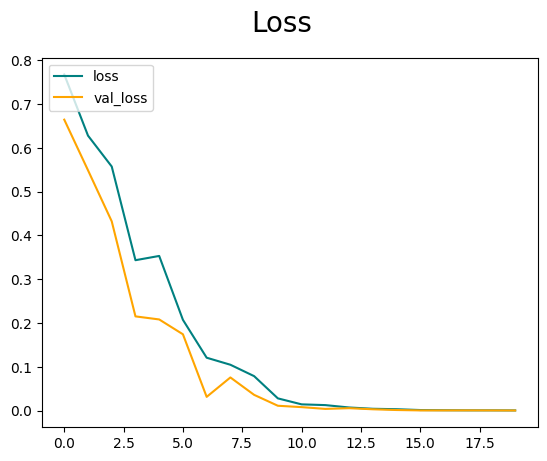

In [43]:
fig = plt.figure()
plt.plot(hist.history['loss'], color ='teal', label ='loss')
plt.plot(hist.history['val_loss'], color ='orange', label ='val_loss')
fig.suptitle('Loss', fontsize =20)
plt.legend(loc='upper left')
plt.show()

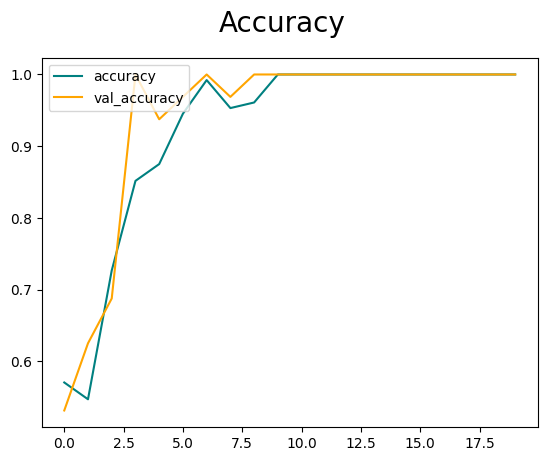

In [44]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color ='teal', label ='accuracy')
plt.plot(hist.history['val_accuracy'], color ='orange', label ='val_accuracy')
fig.suptitle('Accuracy', fontsize =20)
plt.legend(loc='upper left')
plt.show()

# 4 Evaluate Performance

## 4.1 Evaluate

In [45]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [46]:
pre = Precision()
rec = Recall()
bacc = BinaryAccuracy()

In [47]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    bacc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


In [48]:
print(f'Precision : {pre.result().numpy()}, Recall : {rec.result().numpy()}, Binary Accuracy : {bacc.result().numpy()},')

Precision : 1.0, Recall : 1.0, Binary Accuracy : 1.0,


## 4.2 Test 

In [49]:
import cv2

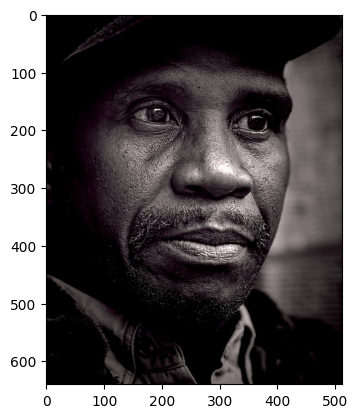

In [50]:
img = cv2.imread('sadtest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

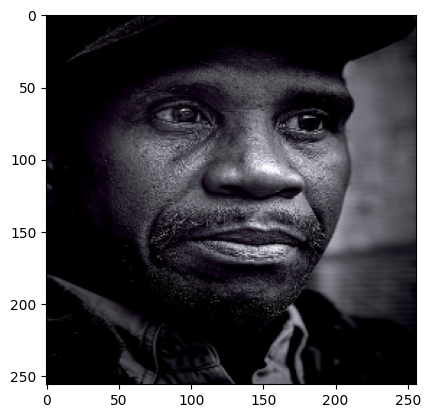

In [51]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [52]:
resize.shape

TensorShape([256, 256, 3])

In [53]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [54]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [55]:
yhat

array([[0.99999386]], dtype=float32)

In [56]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 5. Save the Model

## 5.1 Save the Model

In [57]:
from tensorflow.keras.models import load_model

In [58]:
model.save(os.path.join('models','happysadmodel.keras'))

In [59]:
new_model = load_model(os.path.join('models', 'happysadmodel.keras'))

In [60]:
new_model

<Sequential name=sequential, built=True>

In [61]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


In [62]:
if yhatnew > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# La Finale